<a href="https://colab.research.google.com/github/jnsbrdbr/machine_learning_pojects/blob/master/repo4/Transfomer(ViT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U tensorflow-addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


In [ ]:
num_classes = 10
input_shape = (28, 28, 1)

(x_train1, y_train1), (x_test1, y_test1) = keras.datasets.mnist.load_data()
#(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(f"x_train shape: {x_train1.shape} - y_train shape: {y_train1.shape}")
print(f"x_test shape: {x_test1.shape} - y_test shape: {y_test1.shape}")
#print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
#print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28) - y_train shape: (60000,)
x_test shape: (10000, 28, 28) - y_test shape: (10000,)


In [ ]:
x_train=x_train1.reshape(60000,28,28,1)
y_train=y_train1.reshape(60000,1)
x_test=x_test1.reshape(10000,28,28,1)
y_test=y_test1.reshape(10000,1)

In [ ]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (60000, 28, 28, 1) - y_train shape: (60000, 1)
x_test shape: (10000, 28, 28, 1) - y_test shape: (10000, 1)


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [ ]:
#prevent overfitting
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)#x_train1


In [ ]:

#normalize the contributio of these featurea
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x



In [ ]:
#turn 72 size picture to 6*6 patches
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Image size: 72 X 72
Patch size: 6 X 6
Patches : (1, 144, 36)
Patches per image: 144
Elements per patch: 36


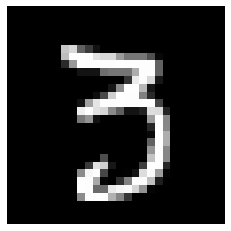

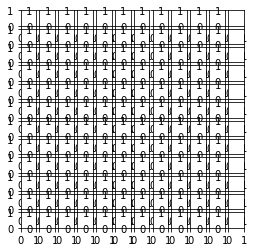

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image1 = x_train1[np.random.choice(range(x_train1.shape[0]))]

plt.imshow(image1.astype("uint8"),cmap="gray")
plt.axis("off")

image = x_train[np.random.choice(range(x_train.shape[0]))]

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches : {patches.shape}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")


plt.figure(figsize=(4, 4))
n = int(np.sqrt(patches.shape[1]))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
   

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/100
211/211 [==============================] - 3451s 16s/step - loss: 1.0340 - accuracy: 0.7118 - top-5-accuracy: 0.9580 - val_loss: 0.2175 - val_accuracy: 0.9370 - val_top-5-accuracy: 0.9965
Epoch 2/100
211/211 [==============================] - 3428s 16s/step - loss: 0.3860 - accuracy: 0.8782 - top-5-accuracy: 0.9934 - val_loss: 0.1157 - val_accuracy: 0.9698 - val_top-5-accuracy: 0.9983
Epoch 3/100
211/211 [==============================] - 3532s 17s/step - loss: 0.2501 - accuracy: 0.9231 - top-5-accuracy: 0.9970 - val_loss: 0.0741 - val_accuracy: 0.9825 - val_top-5-accuracy: 0.9985
Epoch 4/100
211/211 [==============================] - 3628s 17s/step - loss: 0.1989 - accuracy: 0.9394 - top-5-accuracy: 0.9976 - val_loss: 0.0777 - val_accuracy: 0.9803 - val_top-5-accuracy: 0.9985
Epoch 5/100
132/211 [=================>............] - ETA: 21:25 - loss: 0.1745 - accuracy: 0.9466 - top-5-accuracy: 0.9983